In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import FourierKAN
from kans.utils import create_dataset

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
def train(model, train_loader, test_input, test_label, num_epochs=50, save=False, model_name=''):
	print('-'*50)
	print(f'Training {model_name} model...')
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	criterion = nn.MSELoss() # Use MSELoss for regression
	epoch_losses = []
	test_losses = []
	bar = tqdm(total=num_epochs)
	start_t = time.time()
	for epoch in range(num_epochs):
		running_loss = 0.0
		model.train()
		for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
			outputs = model(inputs)
			loss = criterion(outputs, labels)
            
            # Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
            
            # Record loss
			running_loss += loss.item()
        
        # Print information every certain steps
		epoch_loss = running_loss / len(train_loader)
		epoch_losses.append(epoch_loss)
		test_loss = test(model, test_input, test_label, criterion)
		test_losses.append(test_loss)
		bar.set_description(f'{model_name} Epoch {epoch+1}')
		bar.set_postfix(loss=f'{epoch_loss:.4f}', test_loss=f'{test_loss:.4f}')
		bar.update(1)
	bar.close()
	end_t = time.time()
	epoch_time = (end_t - start_t) / num_epochs
	print(f'Average Epoch Training Time :{epoch_time}s')
	if save:
		torch.save(model.state_dict(), f'model/{model_name}.pth')
		print(f'Model saved as model/{model_name}.pth')
	return epoch_losses, test_losses, epoch_time

def test(model, test_input, test_label, criterion):
    model.eval()
    with torch.no_grad():
        test_output = model(test_input)
        test_loss = criterion(test_output, test_label).item()
    return test_loss

In [3]:
# Generate dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
print('train_input size:', dataset['train_input'].shape)
print('train_label',dataset['train_label'].shape)
print('test_input size:', dataset['test_input'].shape)
print('test_label',dataset['test_label'].shape)

# Create data loader
train_dataset = TensorDataset(dataset['train_input'], dataset['train_label'])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_input size: torch.Size([1000, 2])
train_label torch.Size([1000, 1])
test_input size: torch.Size([1000, 2])
test_label torch.Size([1000, 1])


In [4]:
# Create model
layer_sizes = [2,5,3,1]  # Specify the number of nodes per layer
frequency_count = 3  # Frequency count
model = FourierKAN(layer_sizes, frequency_count)
model.to(device)

FourierKAN(
  (layers): ModuleList(
    (0): CustomFourierLayer(
      (fourier_bases): ModuleList(
        (0-4): 5 x ModuleList(
          (0-1): 2 x FourierBasisFunction()
        )
      )
    )
    (1): CustomFourierLayer(
      (fourier_bases): ModuleList(
        (0-2): 3 x ModuleList(
          (0-4): 5 x FourierBasisFunction()
        )
      )
    )
    (2): CustomFourierLayer(
      (fourier_bases): ModuleList(
        (0): ModuleList(
          (0-2): 3 x FourierBasisFunction()
        )
      )
    )
  )
)

In [5]:
# Training process
num_epochs = 50
epoch_losses, test_losses, epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='FourierKAN')

--------------------------------------------------
Training FourierKAN model...


FourierKAN Epoch 50: 100%|██████████████████████████████| 50/50 [01:10<00:00,  1.42s/it, loss=0.0010, test_loss=0.0008]

Average Epoch Training Time :1.4167674732208253s
Model saved as model/FourierKAN.pth


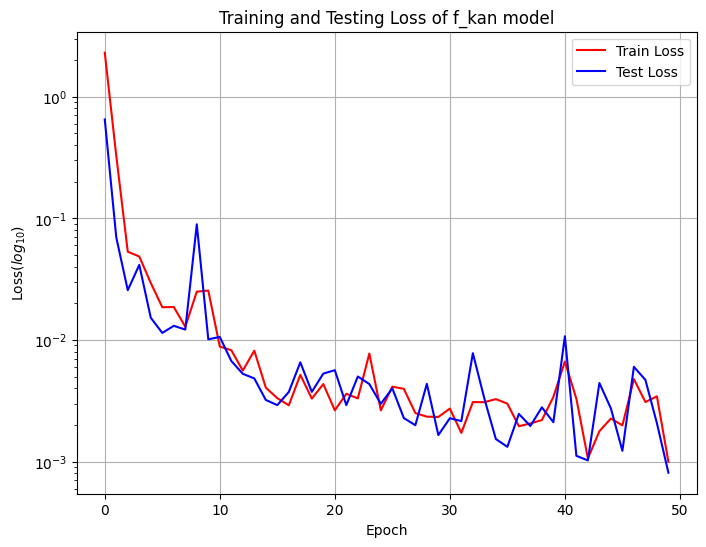

In [6]:
# Plot the loss curve
plt.figure(figsize=(8,6))
plt.plot(epoch_losses, label='Train Loss', color='r')
plt.plot(test_losses, label='Test Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.title('Training and Testing Loss of f_kan model')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Increase the frequency
new_frequency_count=4
model.increase_frequency(new_frequency_count=new_frequency_count)

--------------------------------------------------
Training FourierKAN model...


FourierKAN Epoch 50: 100%|██████████████████████████████| 50/50 [01:12<00:00,  1.44s/it, loss=0.0003, test_loss=0.0002]


Average Epoch Training Time :1.4426107454299926s
Model saved as model/FourierKAN.pth


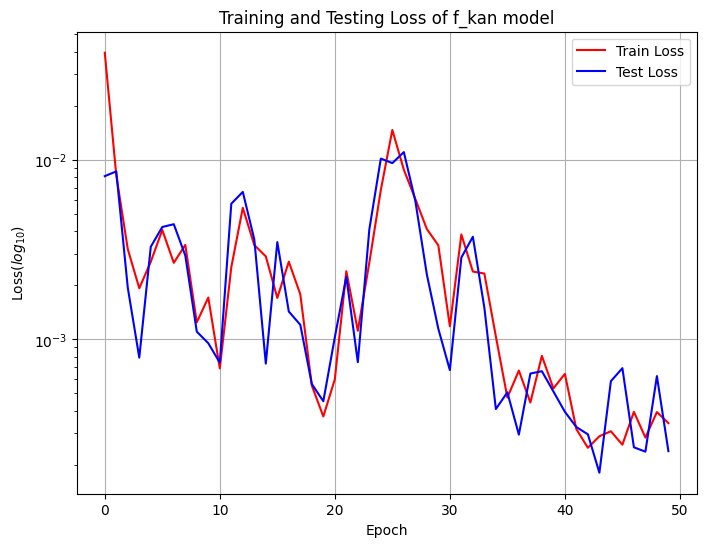

In [8]:
# Training process
num_epochs = 50
epoch_losses, test_losses, epoch_time = train(model, train_loader, dataset['test_input'], dataset['test_label'], num_epochs=num_epochs, save=True, model_name='FourierKAN')

# Plot the loss curve
plt.figure(figsize=(8,6))
plt.plot(epoch_losses, label='Train Loss', color='r')
plt.plot(test_losses, label='Test Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.title('Training and Testing Loss of f_kan model')
plt.grid(True)
plt.legend()
plt.show()